In this project, I analyse the Ame's housing dataset to try to predict prices of housing in Boston. The goal is to leverage powerful Machine Learning techniques to reach the top 5% on the Kaggle competition.
<br><br>

Here I also aim to show the various steps leading up to the final predicitons. Of course, notebooks are linear and an idealisation of the highly iterative process involved in understanding the data, building pipelines, trying models, troubleshooting, but I will try to give a sense of the whole approach.
<br><br>

Let's jump right into it!


Just before, a special acknowledgment for the people who write notebooks that inspired me on kaggle:

<br><br>


# 0. Import libraries

In [46]:
import json
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#ML
import xgboost as xgb
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from mlxtend.regressor import StackingCVRegressor

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler





import scipy as sp
from scipy.special import boxcox1p
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder

## dont want warnings for final version
import warnings
warnings.filterwarnings("ignore")



# 1. load the data set

First we load the data and perform a few initial processing steps

In [21]:
# import data

train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
print(train.shape)
print(test.shape)

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# remove Id col for further preprocessing
train_noid=train.drop('Id',axis=1)
test_noid=test.drop('Id',axis=1)

print(train_noid.shape)
print(test_noid.shape)

# lets also combine train and test for preprocessing
train_nodv=train_noid.drop(columns=["SalePrice"])#remove dv to concatenate
# put dv aside
y=train["SalePrice"]
y_log=np.log(y)
# add info about the original set to which data belongs
tmp_train=train_nodv.copy()
tmp_train["set_id"]="train"
tmp_test=test_noid.copy()
tmp_test["set_id"]="test"
all_data=pd.concat([tmp_train,tmp_test])

all_data.shape


(1460, 81)
(1459, 80)
(1460, 80)
(1459, 79)


(2919, 80)

# 2. First look at the data

The first step is to get a bird eye view of our data. It may be quite complex with many features and complicated relationhips. Let's get genral information from it before diving into the details.

First off, let's see how big is the data we have to deal with

In [22]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


80 features to take into account. That's quite a lot! 
<br>Let's further check our different types of variables to get a bird eye view on our data.

In [23]:
# Get the data types of each column
data_types = train.dtypes

# Count the number of features for each data type
data_type_counts = data_types.value_counts()

print("\nNumber of features of each data type:")
print(data_type_counts)


Number of features of each data type:
object     43
int64      35
float64     3
Name: count, dtype: int64


Almost half are categorical! We'll have to take this into account for further processing and exploration.

# 3. handling missing values

Let's see if we have some missing values.

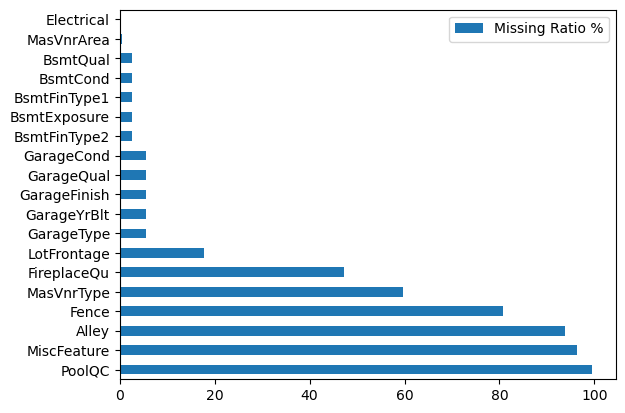

In [24]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')

plot_nas(train)

Some features miss a lot of values. Something that can catch our attention is that various features related to Garages miss exactly the same number of values. Looking at the data description, we see that "na" actually means no garage. And the same happens for other features such as Pool Quality, Fence etc...

<br><br>
We are kinda lucky, our dataset looks to of better quality than the plot above suggests. We can fill most of the nas by replacing by "none" or similar.

In [25]:
def fill_false_nas(df: pd.DataFrame):
    """a lot of nas are actually values representing the absence
    of a feature. We fill these false nas with correct values"""
    #avoid modifying the orginal dataframe
    tmp=df.copy()
    tmp["PoolQC"] = tmp["PoolQC"].fillna("No_Pool")
    
    tmp["MiscFeature"] = tmp["MiscFeature"].fillna("None")
    tmp["Alley"] = tmp["Alley"].fillna("None")
    tmp["Fence"] = tmp["Fence"].fillna("None")
    tmp["MasVnrType"] = tmp["MasVnrType"].fillna("None")
    tmp["MasVnrArea"] = tmp["MasVnrArea"].fillna(0)#0 surface when non masvnr
    
    tmp["FireplaceQu"] = tmp["FireplaceQu"].fillna("None")
    # categorical garage related vars have NA for no garage. 0 in numerical vars
    tmp["GarageType"] = tmp["GarageType"].fillna("None")
    tmp["GarageFinish"] = tmp["GarageFinish"].fillna("None")
    tmp["GarageQual"] = tmp["GarageQual"].fillna("None")
    tmp["GarageCond"] = tmp["GarageCond"].fillna("None")
    # for numerical values related to house without garage, some nas can be replaced by 0.
    tmp["GarageArea"] = tmp["GarageArea"].fillna(0)
    tmp["GarageYrBlt"] = tmp["GarageYrBlt"].fillna(0)
    tmp["GarageCars"] = tmp["GarageCars"].fillna(0)
    
    # basement
    tmp["BsmtQual"] = tmp["BsmtQual"].fillna("None")
    tmp["BsmtCond"] = tmp["BsmtCond"].fillna("None")
    tmp["BsmtExposure"] = tmp["BsmtExposure"].fillna("None")
    tmp["BsmtFinType1"] = tmp["BsmtFinType1"].fillna("None")
    tmp["BsmtFinType2"] = tmp["BsmtFinType2"].fillna("None")
    tmp["BsmtCond"] = tmp["BsmtCond"].fillna("None")
    
    # can assume nas are typical from documentation
    tmp["Functional"] = tmp["Functional"].fillna("Typ")
    
    # numerical columns with nas related to missing bsmt. fill with 0s
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        tmp[col] = tmp[col].fillna(0)
    # utils is not informative almost 100% same value  
    tmp=tmp.drop(['Utilities'],axis=1)
    return tmp


all_data=fill_false_nas(all_data)

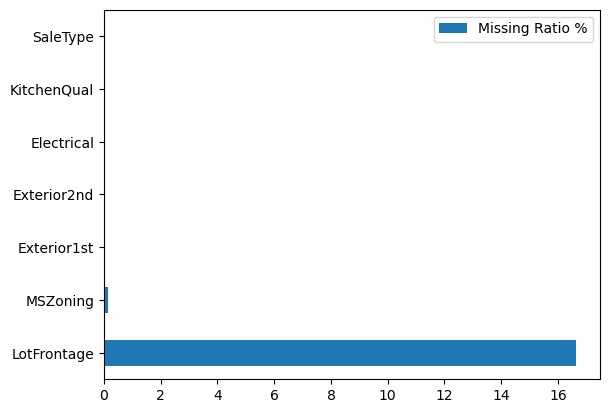

In [26]:
plot_nas(all_data)

Cool! almost no nas left!

for the real missing values that remain, several methods could be applied. Removing the whole row, filling with the mean or mode, or using more advanced machine learning methods to infer the most likely missing values. For example, we could try to use KNN to fill the missing value with the mean of the most similar instances. Here we go simple.

<br><br>
For the features with very few missing values, we will just take the mode, i.e. the most common category for categorical variables.

<br><br> For Lot Frontage, we will try something a bit more thoughtful. Lot Frontage is the length of the property touching the street. We can assume that this value is similar in different neighborhoods, so we will fill this value with the median of each neighborhood. The mean may be distorted by atypical housing with extreme values, so better to go for the median.


In [27]:
def fill_true_nas(df: pd.DataFrame):
    """some features have actual missing values that does not seem to be
    accurately and easily inferred from other features. We use various methods 
    to fill these nas"""
    
    tmp=df.copy() # avoid modifying the original df
    # we replace these nas with the most common value
    mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
    for col in mode_col:
        tmp[col] = tmp[col].fillna(tmp[col].mode()[0])
    #same filling with mode for this feature
    tmp["MSZoning"]=tmp["MSZoning"].fillna(tmp["MSZoning"].mode()[0])
    #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    tmp["LotFrontage"] = tmp.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    return tmp

all_data=fill_true_nas(all_data)

In [28]:
plot_nas(all_data)

No NAs found


Done with the missing values!

# 4. EDA: Quick insights on data

Now we'd like to get preliminary insights on which features best explain housing prices. Correlation is the go to method. But here, as we have a mix of categorical and numerical features, it is limited as it won't capture associations of categorical variables with price.

So, let's use mutual information to quatify dependencies between variables. It tells us roughly how knowing one variable x gives information about another variable y. It typically ranges between 0 (no association) and 2 (high association), although it has no upper bound.

In [29]:
# get the training set back from processed data
X=all_data[all_data["set_id"]=="train"].copy()

#do label encoding on categorical variable to perform mi ana
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == "int64"

# extract colnames of discrete features for mi computation
discrete_features = X.select_dtypes(include='object').columns.tolist()
print(discrete_features)



# make a boolean mask to indicate if col is categorical (True) or not (False)
# to feed to mi function
discrete_features_bool=[]
for col in X.columns.tolist():
    if col in discrete_features:
        discrete_features_bool.append(True)
    else:
        discrete_features_bool.append(False)


[]


In [30]:
def make_mi_scores(X, y, discrete_features):
    # run mutual info regression
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    # turn it to series
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # sort it
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features_bool)
mi_scores[::3]  # show a few few

OverallQual      0.571480
TotalBsmtSF      0.369755
GarageCars       0.355238
KitchenQual      0.316231
GarageFinish     0.271945
YearRemodAdd     0.242296
Foundation       0.202070
GarageType       0.198781
LotArea          0.158953
BsmtFinType1     0.152258
Exterior1st      0.120461
OverallCond      0.105223
MasVnrArea       0.086693
LotShape         0.079241
SaleCondition    0.076530
CentralAir       0.067228
Electrical       0.054516
KitchenAbvGr     0.041102
Alley            0.028092
Heating          0.016368
Functional       0.014942
BsmtFinSF2       0.008046
ScreenPorch      0.007168
Street           0.001982
PoolArea         0.000000
MiscVal          0.000000
LowQualFinSF     0.000000
Name: MI Scores, dtype: float64

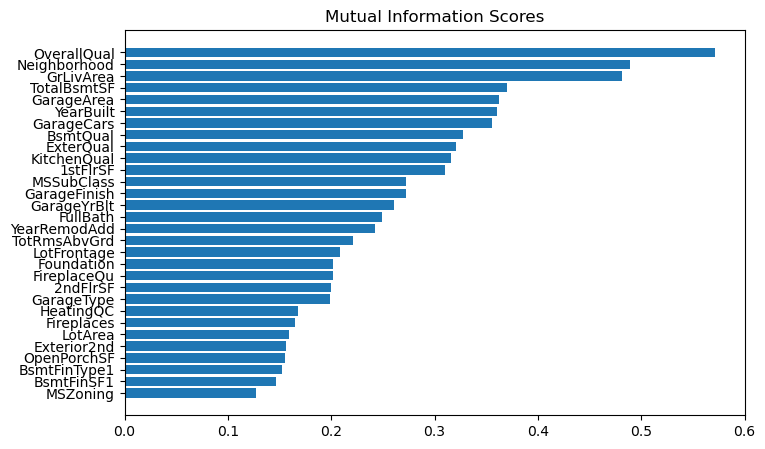

In [31]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[:30])

We can see that we have an overall quality feature that contains a lot of information about housing price. The neighborhood of course is a very important factor.

<br><br>
One surprising finding is that the total surface of the basement is one of the most important predictor of the housing price! But it may hint at some issue with our high dimensional data set: multicollinearity. It is most likely highly correlated with other variables such as the the ground living area. 

<br><br>
We can guess that many variables will be highly correlated. For example, the number of cars that the garage can contain (GarageCars) and its area (GarageArea).

<br><br>
We will have to deal with that, as some machine learning models (eg linear regression) will not handle multicolinearity well.


let's take a quick look at our correlation matrix (numerical data only)

<Figure size 1500x1000 with 0 Axes>

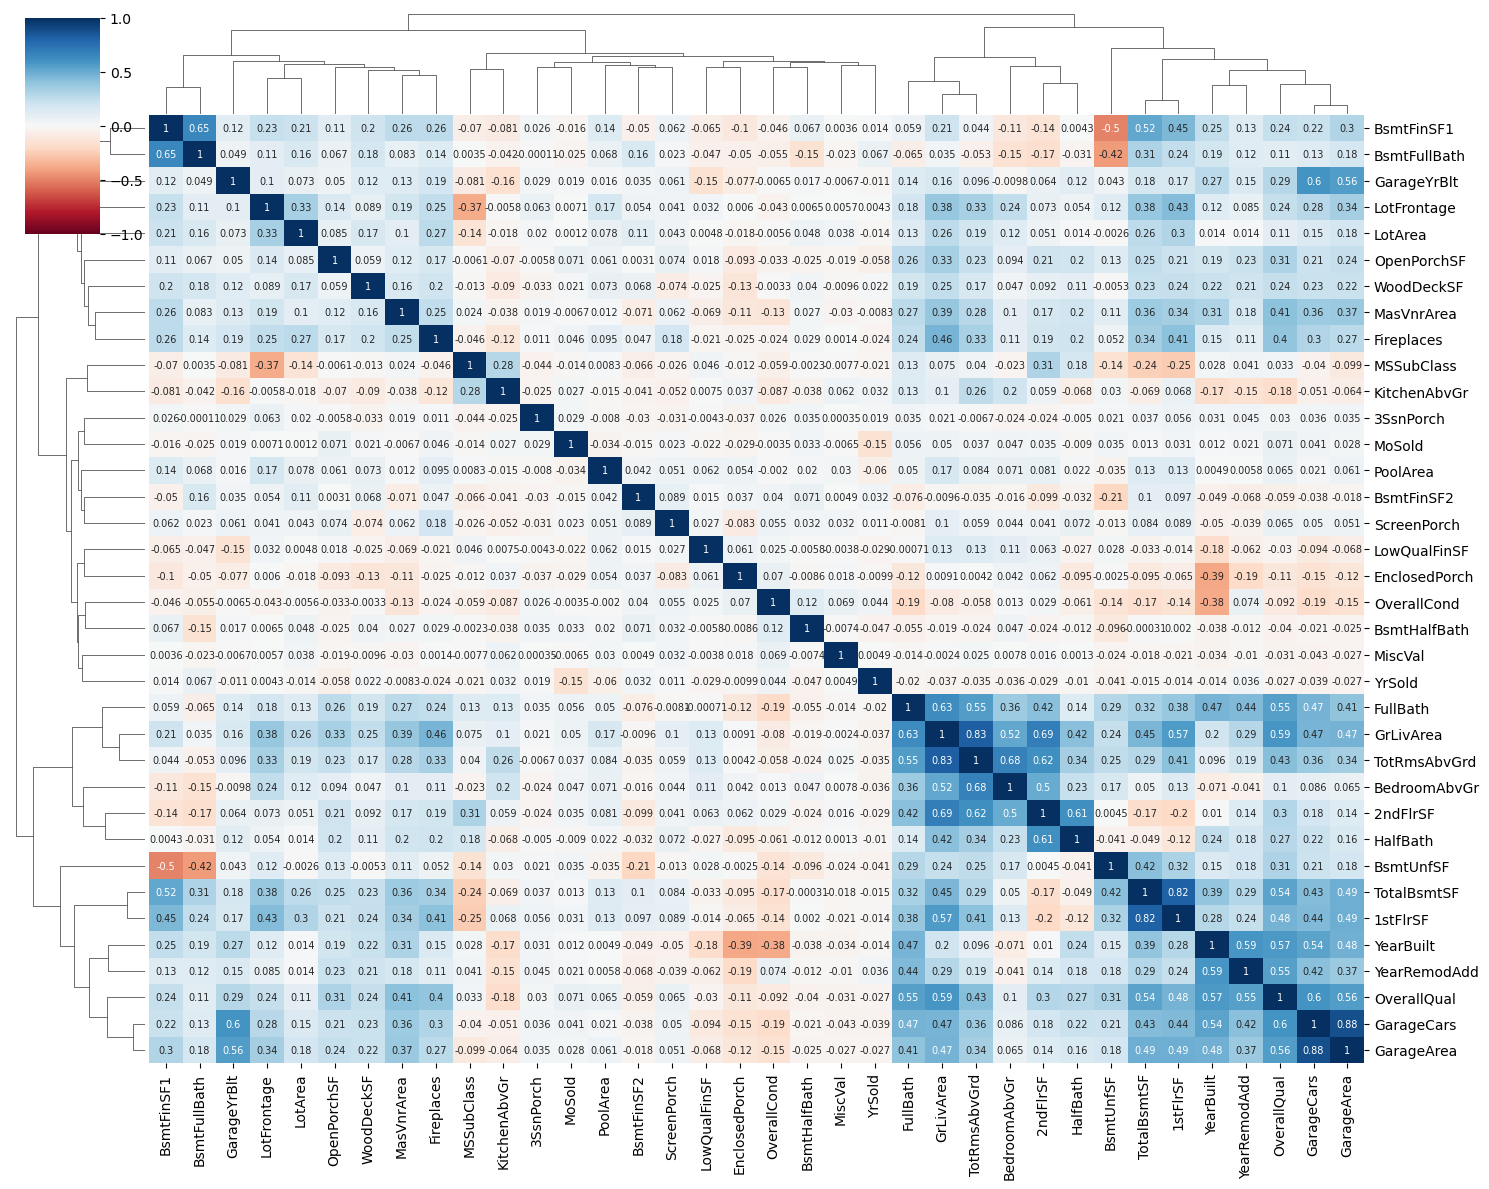

In [32]:
plt.figure(figsize=(15,10))
# extract training data
train_num=all_data[all_data["set_id"]=="train"].copy()
#keep only numerical variables
train_num=train_num.select_dtypes(include=[ 'number'])

correlations = train_num.corr()

sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12),dendrogram_ratio=(.1, .1));

We indeed see a correlation between Ground living area (GrLivingArea) and the basement surface (TotBsmtSF), which is one of many

# 5. EDA: plotting variables

## 5.0. check dependent variable

<Axes: xlabel='SalePrice', ylabel='Count'>

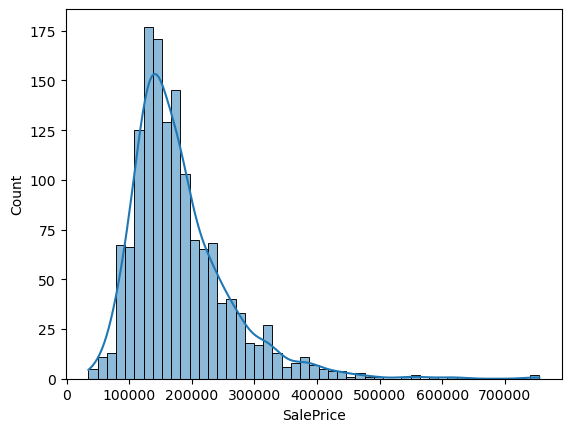

In [33]:
sns.histplot(y,kde=True)


It looks like we have an exponential distribution, positively skewed. This will badly impact our models training. We should transform it to a normal distribution.

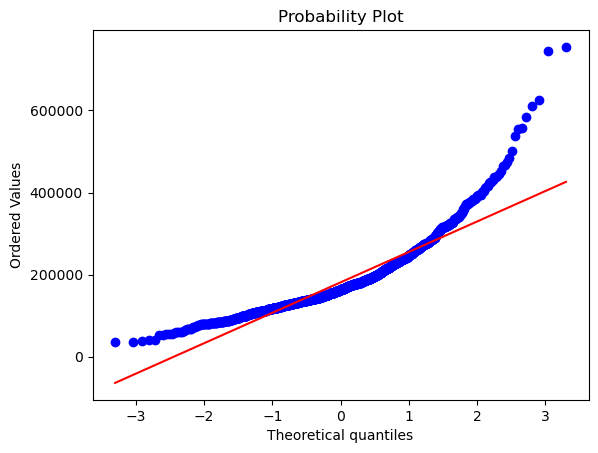

In [34]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
fig = plt.figure()
res = stats.probplot(y, plot=plt)

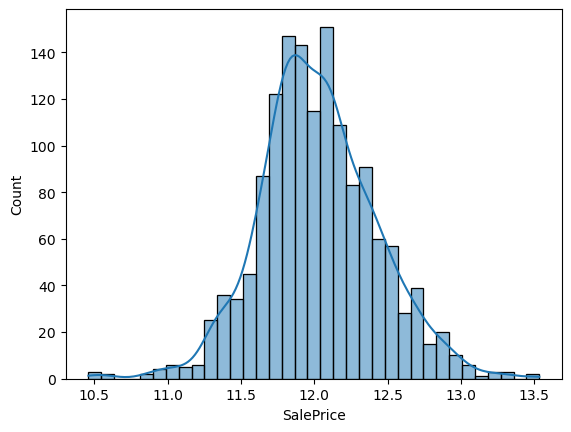

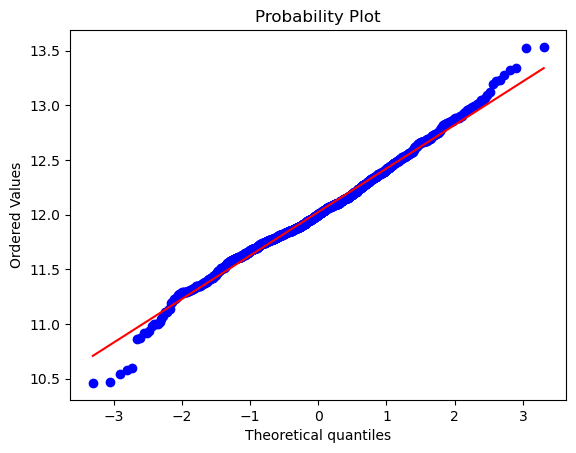

In [35]:
y_log=np.log(y)
sns.histplot(y_log,kde=True)
ig = plt.figure()
res = stats.probplot(y_log, plot=plt)

## 5.1 univariate distribution

with all the features we have, it may be a bit tricky to analyse each features individually. But it's always good to take a look at it to see if anything obvious appears.

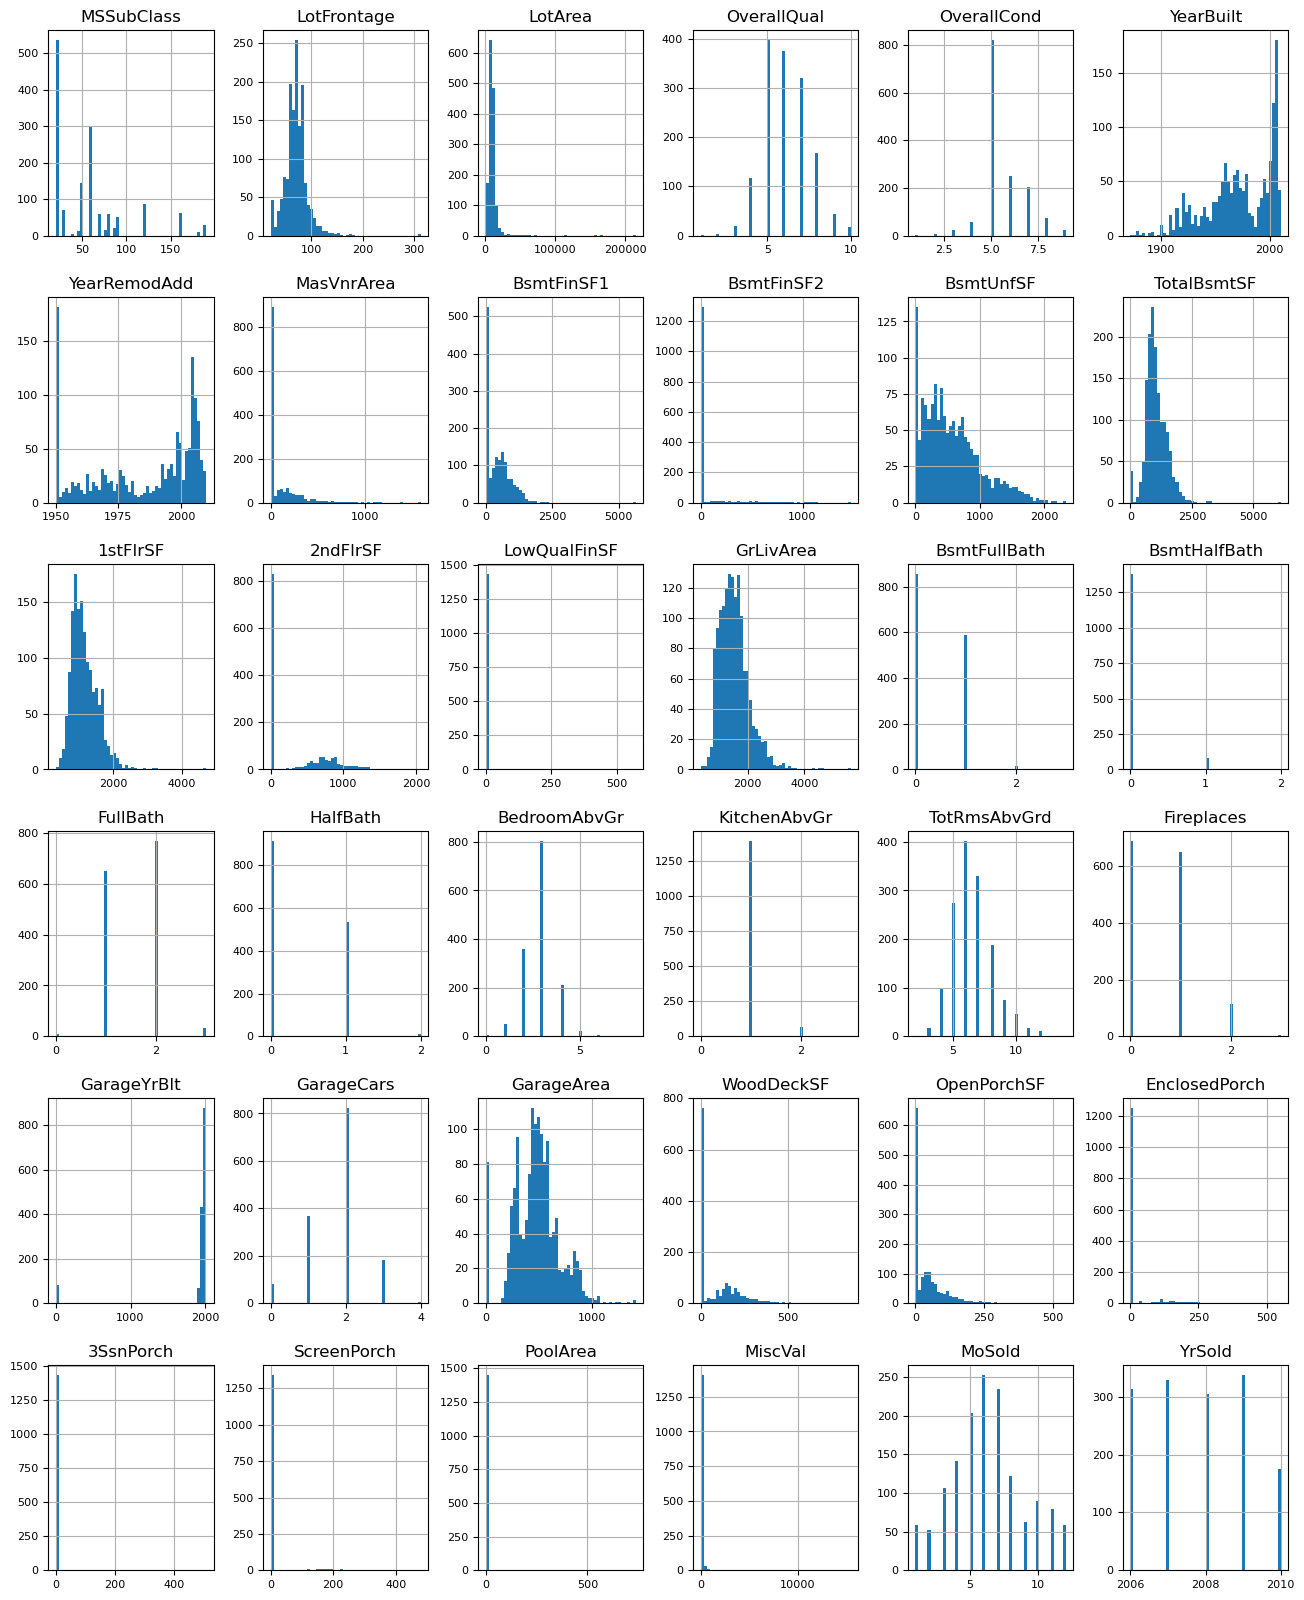

In [36]:
train_nona=all_data[all_data["set_id"]=="train"].copy()
train_nona.select_dtypes("number").hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


We see that some variables are not normally distibuted, particularly in connection to surface (e.g. bsmtUniSF). We will try to correct the skew to make the training of the models easier. We can also see that many variables (e.g. WoodDeckSF) contain a lot of 0 values, indicating the absence of the features, making the variable non normally distributed.

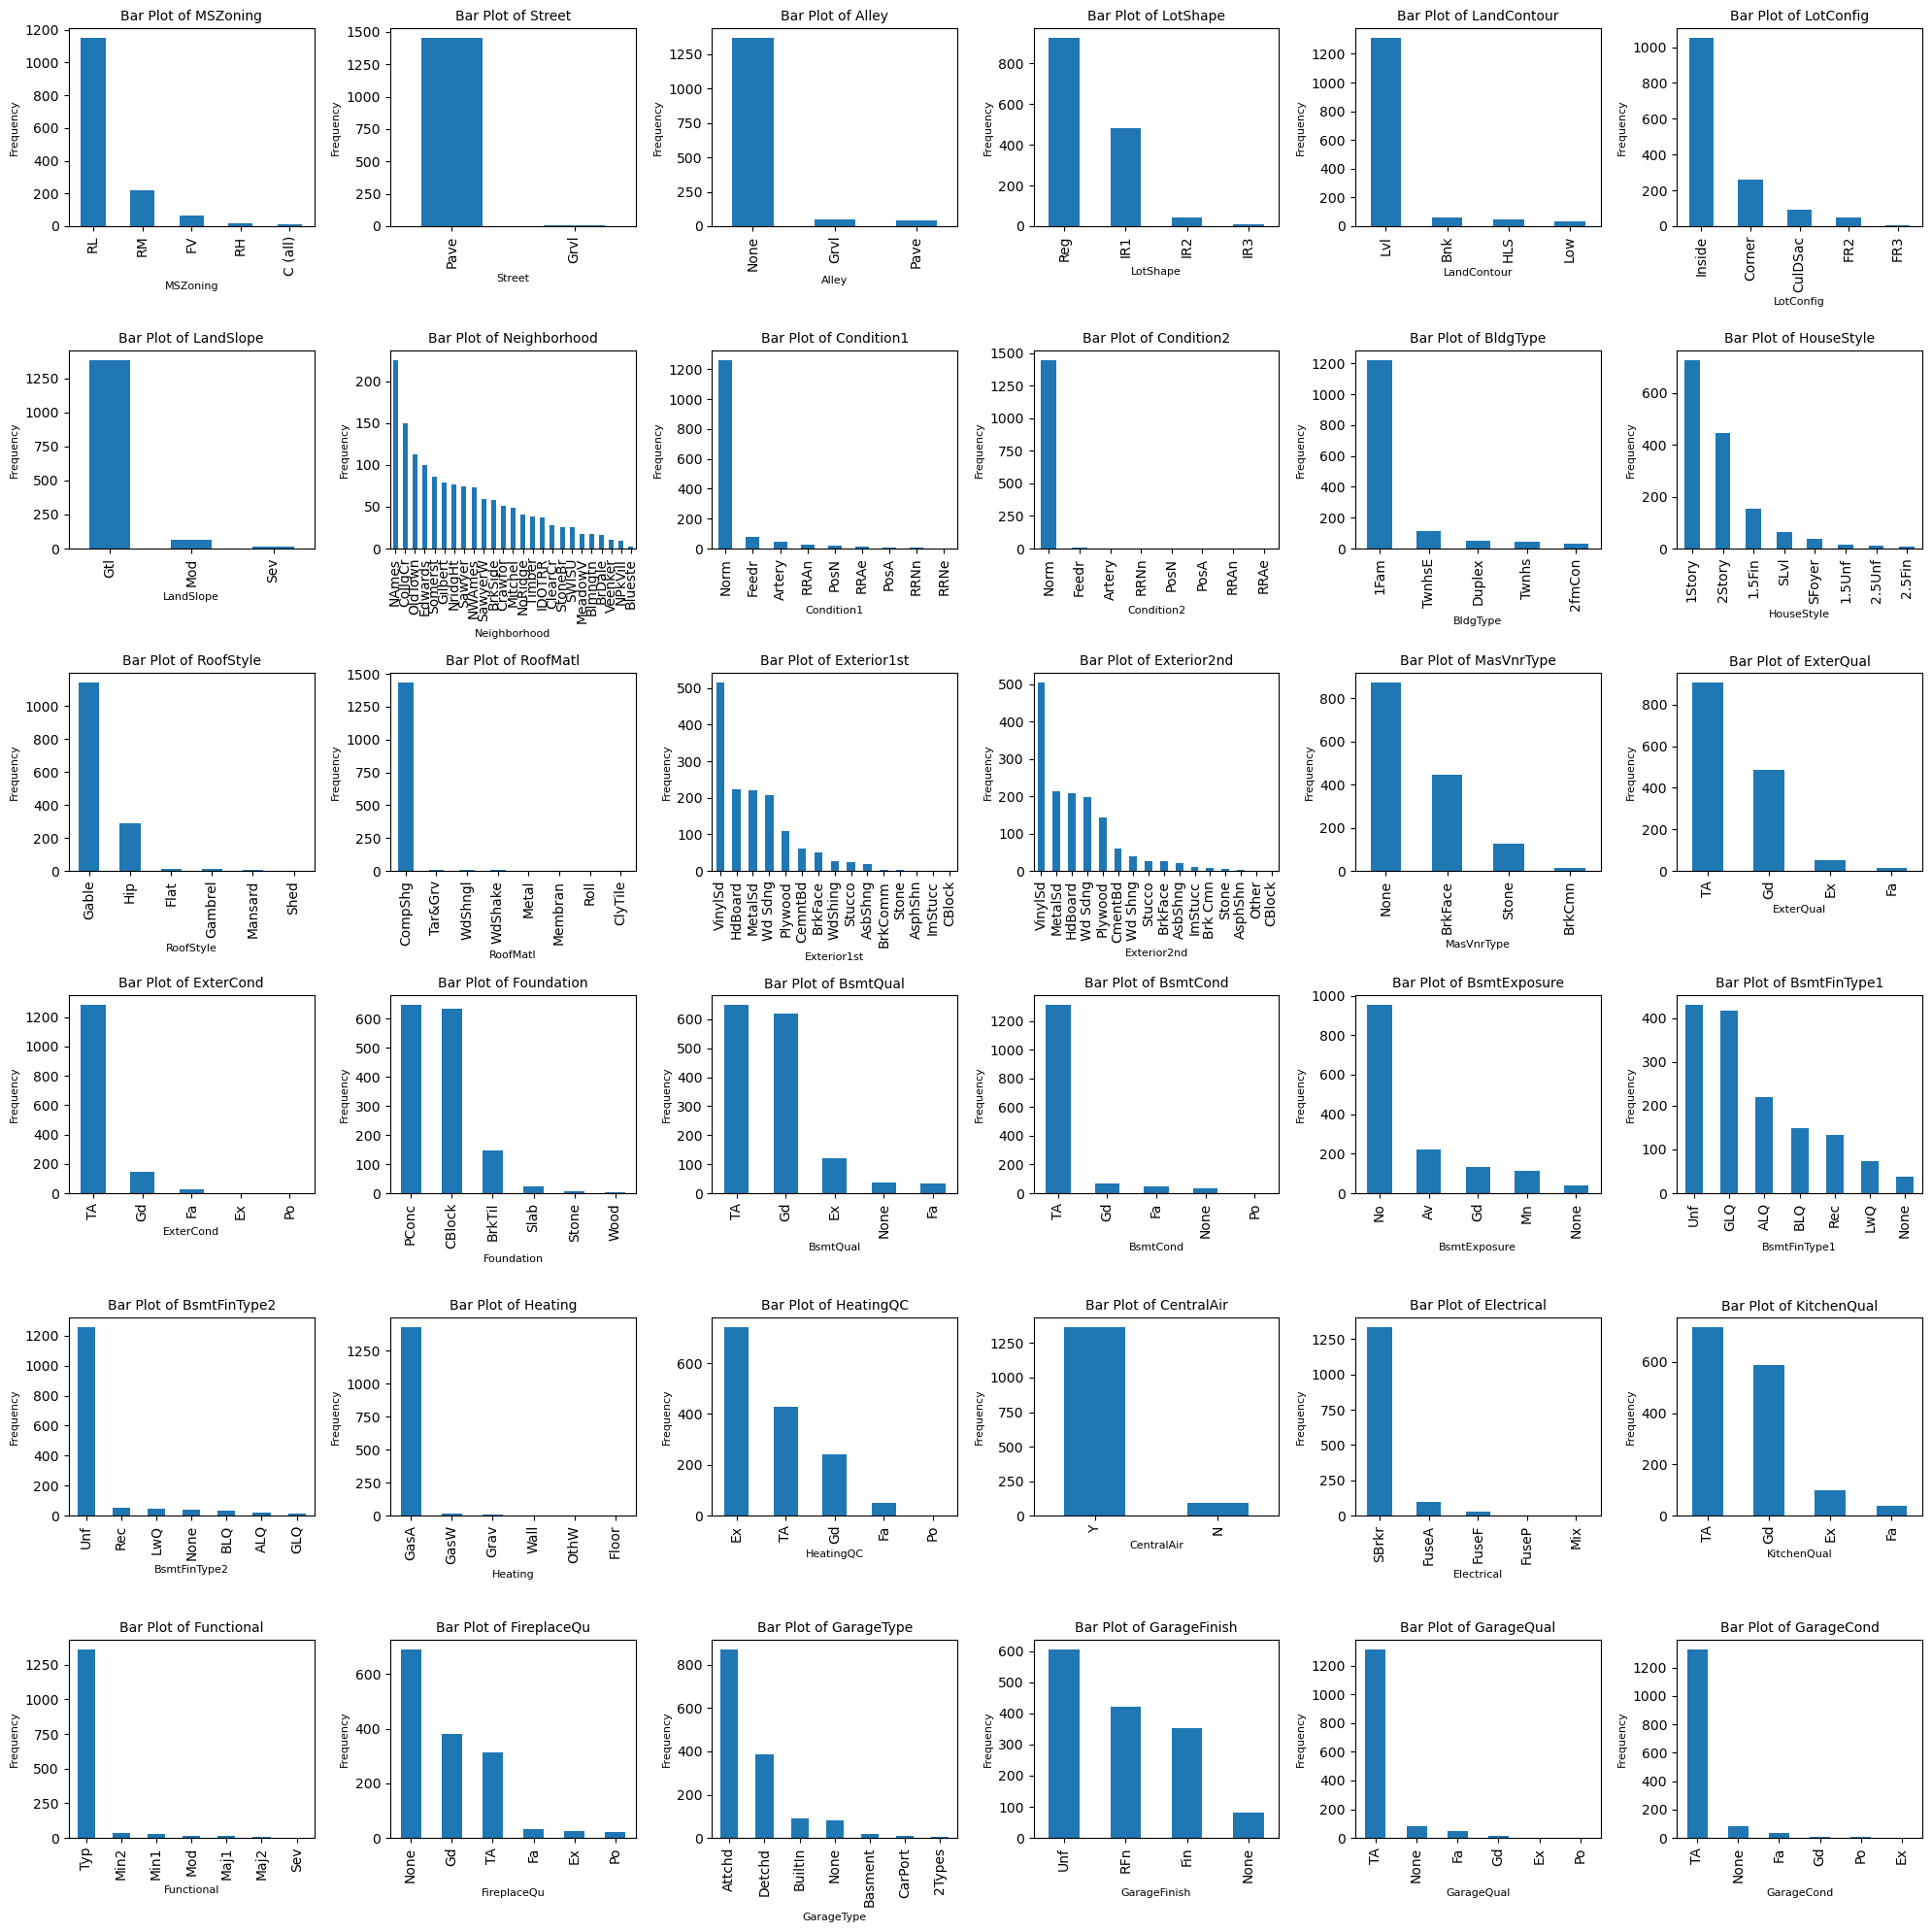

In [37]:


# Selecting categorical columns
categorical_df = train_nona.select_dtypes("object")

# Limit the number of subplots to 36
num_rows = min(6, len(categorical_df.columns))
num_cols = min(6, len(categorical_df.columns))

# Create a new figure and adjust the size
plt.figure(figsize=(20, 20))

# Plotting bar plots for each categorical variable
for i, column in enumerate(categorical_df.columns[:num_rows*num_cols]):
    # Create a new subplot in the grid
    plt.subplot(num_rows, num_cols, i+1)
    
    # Plot the bar plot for the current categorical variable
    categorical_df[column].value_counts().plot.bar()
    
    # Set labels and title for the subplot
    plt.xlabel(column, fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.title(f'Bar Plot of {column}', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We see (with a little zoom) that some features have very rare values. For example condition 2 has almost all observations condensed in one class.

## 5.2. bivariate visualization

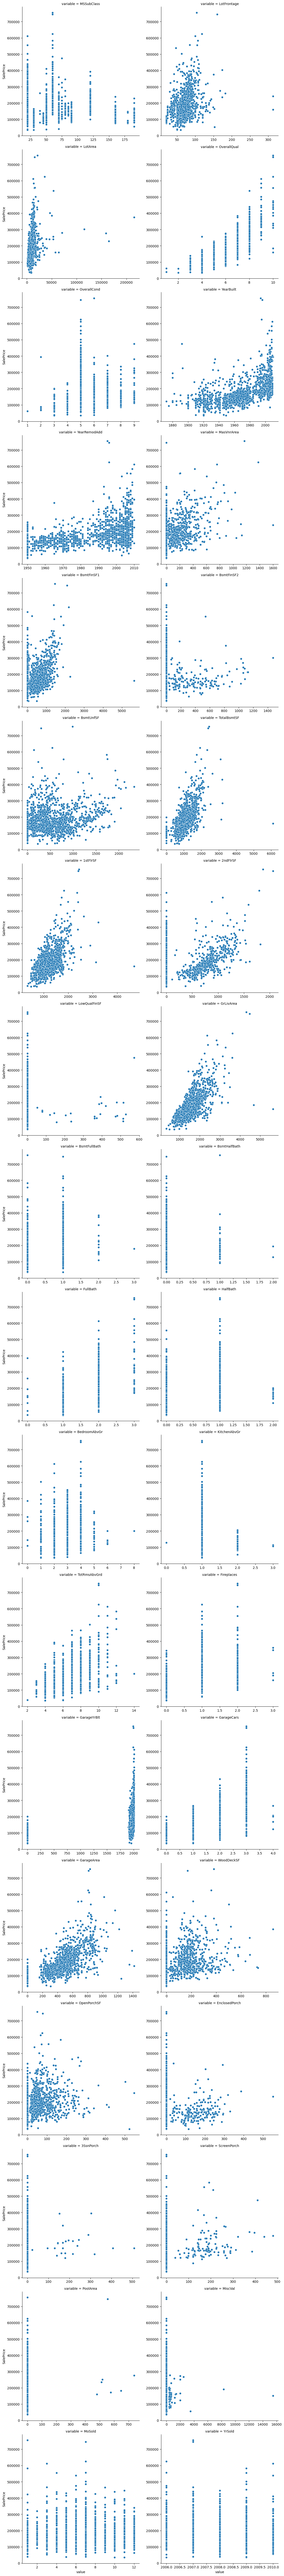

In [38]:
train_nona["SalePrice"]=y
numeric_cols=train_nona.select_dtypes("number").columns
def scatter_plot(x, y, **kwargs):
    sns.scatterplot(x=x, y=y)
    #x=plt.xticks(rotation=90)
f = pd.melt(train_nona, id_vars=['SalePrice'], value_vars=numeric_cols)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False,height=6,aspect=1)
g = g.map(scatter_plot, "value", "SalePrice")

For example, GrLivingArea seem to have outliers with very big surfaces for very low prices. This may hurt the training of our model, so we will remove it

An because I like boxplots

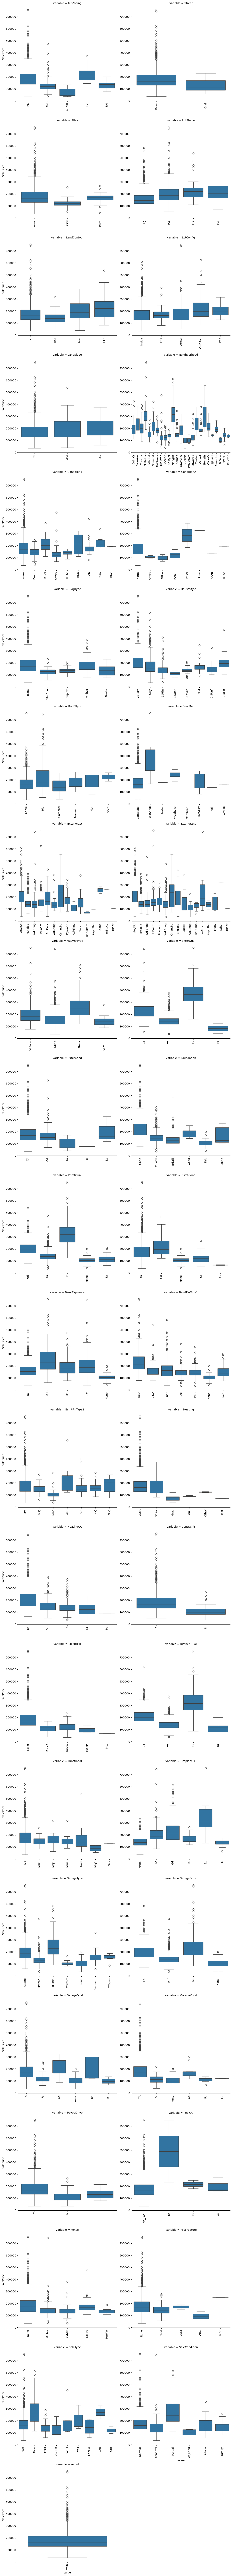

In [39]:
qualitative=train_nona.select_dtypes(exclude="number").columns


def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train_nona, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False,height=6,aspect=1)
g = g.map(boxplot, "value", "SalePrice")

As expected, we see big variations in prices depending on neighborhood. We see that some categorical variables can be understood as ordinal variables. For example. For example the prices for levels of external quality seem to increase monotically with quality rating (Fa<TA<Gd<Ex)

# 6. Outlier processing

We keep outlier removal minimal here.

In [40]:
def remove_outliers_picked(df: pd.DataFrame,y):
    """remove handpicked outliers
    
    input:
        df: the combined dataset with train and test
        (will handle train and test thanks to a col
         set_id in the df)
        y: the column of the dependent variable.
        need to include it as it is a criteria for outlier removal
    """
    tmp=df.copy()
    # take substet of data pertaining to training set
    #print(tmp.shape)
    tmp["SalePrice"]=y
    tmp_test=tmp[tmp['set_id'] == 'test']
    tmp=tmp[tmp['set_id'] == 'train']
    # print(tmp.shape)
    
    #remove outliers in GrLivarea
    tmp = tmp.drop(tmp[(tmp['GrLivArea']>4000) & (tmp['SalePrice']<300000)].index)
    # print(tmp.shape)
    #extract new dv column (only there on training set)
    y_new=tmp['SalePrice']
    
    # concatenate train and test
    tmp_all=pd.concat([tmp,tmp_test])
    # print(tmp_all.shape)
    
    # remove dv from feature df
    tmp_all = tmp_all.drop(columns=['SalePrice'])
    # print(tmp_all.shape)
    # raise SystemExit("This function is not implemented yet.")
    return tmp_all,y_new

all_data,y_no_out=remove_outliers_picked(all_data,y)

# 7. fix skewed variables

In [41]:
def transform_distribution_features_simple(df: pd.DataFrame, lam=0.15):
    """do a box cox transformation on all numeric features
    with pre set parameter
    we just try to reduce slightly skewness of features
    
    required imports:
        from scipy.special import boxcox1p
        from scipy.stats import skew

    """
    
    tmp=df.copy()#copy to avoid modif original df

    # # Check if all columns in the DataFrame are numeric
    # if not all(pd.api.types.is_numeric_dtype(tmp[col]) for col in tmp.columns):
    #     raise ValueError("All columns in the input DataFrame must be numeric")
    
    # check which features are skewed
    #only look into numeric features
    numeric_feats = tmp.dtypes[tmp.dtypes != "object"].index
    skewed_feats = tmp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    # print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
   
    # select only most skewed features
    skewness_filt=skewness[abs(skewness["Skew"])>1]# abs to see positive and negative skew
   
    skewed_features = skewness_filt.index
    #apply box cox transform with preset lam parameter
    for feat in skewed_features:
        #all_data[feat] += 1
        tmp[feat] = boxcox1p(tmp[feat], lam)
    return tmp
all_data=transform_distribution_features_simple(all_data)

# 8. encode categorical features

We use a mix of label encoding and one hot encoding to avoid increasing dimensionality too much with one hot encoding.

In [42]:
def label_encoding_subset(df:pd.DataFrame):
    """we use label encoding for a subset of features
    
    requires:
        from sklearn.preprocessing import LabelEncoder
"""
    tmp=df.copy()#dont modify original data
    # print("shape befor processing:  ", tmp.shape)
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold')
    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(tmp[c].values)) 
        tmp[c] = lbl.transform(list(tmp[c].values))

    return tmp

all_data=label_encoding_subset(all_data)

In [43]:
def one_hot_encoding(df):
    tmp=df.copy()
    # remove set_id for processing
    set_id=tmp["set_id"]
    tmp=tmp.drop(columns=["set_id"])
    # one hot encode
    tmp = pd.get_dummies(tmp)*1#*1to turn booleans to num
    # tmp.shape
    # put set_id col back
    tmp["set_id"]=set_id
    return tmp
all_data=one_hot_encoding(all_data)

In [44]:
all_data.shape

(2917, 220)

# 9. normalize features

Having features's values on different scales can hurt model training (especially linear regressions), so, better to normalize them

<br><br> We keep it simple here with a min max normalization to bound values between 0 and 1. One may consider more advanced methods such as the robust scaler from scikit-learn, to try to reduce outliers influence a bit more.

In [47]:
def normalize_robust(df: pd.DataFrame):
    """ applies robust scaler function from sklearn to 
    all numerical column in the dataframe
    
    requires:
    from sklearn.preprocessing import RobustScaler
    """
    tmp=df.copy()#copy to avoid modif original df
    
    # separate num and categ vars
    tmpnum=tmp.select_dtypes(include="number")
    tmpcatag=tmp.select_dtypes(exclude="number")
    
    # instanciate scaler and fit
    scaler=RobustScaler().fit(tmpnum)
    # create scaled array
    scaled_array=scaler.transform(tmpnum)
    # convert back to dataframe
    tmpnum_norm = pd.DataFrame(scaled_array, columns=tmpnum.columns, index=tmpnum.index)

    #concat num and categ df
    tmp_norm=pd.concat([tmpnum_norm, tmpcatag], axis=1)
    return tmp_norm

all_data=normalize_robust(all_data)

In [48]:
all_data.describe()

MSSubClass  LotFrontage      LotArea       Street        Alley  \
count  2917.000000  2917.000000  2917.000000  2917.000000  2917.000000   
mean      0.044338    -0.171415    -0.094637    -0.004114    -0.014398   
std       0.724392     1.121386     1.147846     0.064018     0.260180   
min      -0.666667    -3.794380    -3.948543    -1.000000    -1.000000   
25%      -0.666667    -0.530036    -0.530390     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.333333     0.469964     0.469610     0.000000     0.000000   
max       1.833333     5.881710     9.178088     0.000000     1.000000   

          LotShape    LandSlope  OverallQual  OverallCond    YearBuilt  ...  \
count  2917.000000  2917.000000  2917.000000  2917.000000  2917.000000  ...   
mean     -0.350589     0.053822     0.043195     0.564964    -0.035667  ...   
std       0.469914     0.248831     0.703352     1.113414     0.630979  ...   
min      -1.000000     0.000000    -2.500000    -4.000000    -2.104167  ...   
25%      -1.000000     0.000000    -0.500000     0.000000    -0.416667  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.500000     1.000000     0.583333  ...   
max       0.000000     2.000000     2.000000     4.000000     0.770833  ...   

       SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
count     2917.000000   2917.000000   2917.000000  2917.000000   
mean         0.002743      0.081248      0.002400    -0.134042   
std          0.052306      0.273262      0.048937     0.340756   
min          0.000000      0.000000      0.000000    -1.000000   
25%          0.000000      0.000000      0.000000     0.000000   
50%          0.000000      0.000000      0.000000     0.000000   
75%          0.000000      0.000000      0.000000     0.000000   
max          1.000000      1.000000      1.000000     0.000000   

       SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
count            2917.000000            2917.000000           2917.000000   
mean                0.065135               0.004114              0.008228   
std                 0.246807               0.064018              0.090348   
min                 0.000000               0.000000              0.000000   
25%                 0.000000               0.000000              0.000000   
50%                 0.000000               0.000000              0.000000   
75%                 0.000000               0.000000              0.000000   
max                 1.000000               1.000000              1.000000   

       SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
count           2917.000000           2917.000000            2917.000000  
mean               0.015770             -0.176551               0.083305  
std                0.124604              0.381354               0.276390  
min                0.000000             -1.000000               0.000000  
25%                0.000000              0.000000               0.000000  
50%                0.000000              0.000000               0.000000  
75%                0.000000              0.000000               0.000000  
max                1.000000              0.000000               1.000000  

[8 rows x 219 columns]

# 10. Machine learning models

Good. So, now our data is ready to be fed to machine learning models. Given our high dimensional dataset with multicolinearity, it will be important to use that fit fo the challenge. We'll aim to make an ensemble of models to maximize our predictions accuracy.

In [49]:

#split training and test set
#train
train_data_proc=all_data[all_data["set_id"]=="train"]
train_data_proc=train_data_proc.drop(columns=["set_id"])#rmv set_id col useless
#test
test_data_proc=all_data[all_data["set_id"]=="test"]
test_data_proc=test_data_proc.drop(columns=["set_id"])#rmv set_id col useless

print(train_data_proc.shape, test_data_proc.shape)

#apply log transform on dv
y_log=np.log(y_no_out)

# split the training set further in a training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_data_proc, y_log, random_state=1,test_size=0.3)
print(X_train.shape,X_val.shape)






(1458, 219) (1459, 219)
(1020, 219) (438, 219)


## Lasso

As we have a lot of features, a Lasso regression is a good start. It uses a regularization term (L1 norm) that reduces overfitting and performs feature selection by reducing some parameters' coefficient to 0.

In [50]:
# Define the model with LassoCV
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, random_state=42)

# Train the model with cross-validation
lasso_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print("Best alpha: ", best_alpha)

# Make predictions on the training set
y_train_pred = lasso_cv.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Make predictions and evaluate the model
y_pred_cv = lasso_cv.predict(X_val)
mse_cv = mean_squared_error(y_val, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)
print("Validation RMSE with best alpha: ", rmse_cv)

Best alpha:  0.0004498432668969444
Training RMSE:  0.09164976711016938
Validation RMSE with best alpha:  0.1208828447854436


## Ridge regression

Then we try a ridge regression. It also uses a regularisation (L2 norm) parameter to prevent overfitting. On top of this, we use a polynomial kernel to capture non linear relationships.

In [51]:

### perform grid search to find best parameters
### commented to save running time
# kr = GridSearchCV(
#     KernelRidge(kernel="poly"),
#      ## best
#     param_grid={"alpha": np.logspace(np.log10(0.0001),np.log10(1),10),
#                 "degree": [2],
#                 "coef0":np.linspace(100,1000,10)
#                },
# )
# kr.fit(X_train,y_train)

# #check best parameters
# print("Best parameters found: ", kr.best_params_)
# print("Best cross-validation MSE: ", -kr.best_score_)

# #predict training set
# y_train_pred=kr.predict(X_train)

# # Calculate RMSE for the training set
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# print("Training RMSE: ", rmse_train)



# # Evaluate the model on the validation set
# y_val_pred = kr.predict(X_val)
# mse_val = mean_squared_error(y_val, y_val_pred)
# rmse_val = np.sqrt(mse_val)
# print("Validation RMSE: ", rmse_val)


# ## save model and best params

# kr_best_params =kr.best_params_

# # Save best params to a JSON file
# with open('../models/best_params_ridge.json', 'w') as f:
#     json.dump(kr_best_params, f)

# with open('../models/grid_search_ridge.pkl', 'wb') as f:
#     pickle.dump(kr, f)


In [52]:
kr_best_params={'kernel':'poly','alpha': 1.0, 'coef0': 100.0, 'degree': 2}

kr_best=KernelRidge(**kr_best_params)
kr_best.fit(X_train, y_train)

#eval performances on training set
#predict training set
y_train_pred=kr_best.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)



# Evaluate the model on the validation set
y_val_pred = kr_best.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


Training RMSE:  0.07396209193291581
Validation RMSE:  0.135427603712106


## XGBoost

XGBoost is one of the most popular machine learning algorithms, often delivering state-of-the-art performance. It employs gradient boosting, which starts with simple decision trees and iteratively improves them to reduce prediction errors. The final model is a weighted combination of all the decision trees created during the process.

In [54]:
# # the grid search for best params. beware, time consuming to run
# ## just load best parameters to save time

# # Define the model
# model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'alpha': [0, 0.1, 1],
#     'lambda': [1, 1.5, 2]
# }

# # Perform grid search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", -grid_search.best_score_)

# # Train model with best parameters
# best_params = grid_search.best_params_
# best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
# best_model.fit(X_train, y_train)

# # Save best params to a JSON file
# with open('best_params_xgboost_rob_scaling.json', 'w') as f:
#     json.dump(best_params, f)

# with open('grid_search_xgboost_rob_scaling.pkl', 'wb') as f:
#     pickle.dump(grid_search, f)

In [55]:
# optimized parameters
xgb_best_params={'alpha': 0.01,
            'colsample_bytree': 0.9,
            'lambda': 1.5,
            'learning_rate': 0.1,
            'max_depth': 3,
            'n_estimators': 300,
            'subsample': 0.8}

# instanciate model and fit
best_model = xgb.XGBRegressor(**xgb_best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Calculate RMSE for the training set
y_train_pred=best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Evaluate the model
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

final_xgb=best_model

Training RMSE:  0.04568340137658332
Validation RMSE:  0.12089301041981602


## Support vector machine

Support vector machine (SVM) are also an interesting algorithm for regression, although it tends to scale less well with big data. It maps all data points to high dimensional space and tries to find a hyper plane reduces prediction error. I use a non linear kernel to capture non linear relationships.

In [ ]:
# ## fine tune parameters
# ## skip to save time
# from sklearn.svm import SVR

# param_grid = {
#     'kernel': [ 'rbf'],
#     'C': [10,18,20,22,30],
#     'epsilon': [0.001, 0.01,0.02,0.03],
#     'gamma':[0.0001,0.0005,0.0006,0.0007,0.0008]
#     #'gamma': ['scale', 'auto',0.00001,0.0001,0.001,0.01,0.1,1,5,10]  # Only for RBF kernel
# }
# # Instantiate SVM regressor
# svm_regressor = SVR()

# # Perform grid search
# grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation RMSE: ", -grid_search.best_score_)

# # Make predictions on the training set
# y_train_pred = grid_search.predict(X_train)
# # Calculate RMSE for the training set
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# print("Training RMSE: ", rmse_train)


# # Make predictions and evaluate the model
# y_pred = grid_search.predict(X_val)
# mse = mean_squared_error(y_val, y_pred)
# rmse = np.sqrt(mse)
# print("Validation RMSE: ", rmse)

In [56]:
best_params_svm={'C': 22, 'epsilon': 0.02, 'gamma': 0.0005, 'kernel': 'rbf'}
# Instantiate and train the SVM regression model
svm = SVR(**best_params_svm)
svm.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = svm.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = svm.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


Training RMSE:  0.07647272681281253
Validation RMSE:  0.1245469220640042


## Random forest

Random forest is an ensemble algorithm based on decision trees similar to XGBoost. Instead of improving trees sequentially, random forest trains multiple trees independently and averages their final prediction.

In [ ]:
# ### fine tuning

# # Define the model
# rf = RandomForestRegressor(random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [800, 1000,1200],
#     'max_depth': [10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [2, 4,6],
#     'max_features': ['auto', 'sqrt', 'log2',None],
#     'bootstrap': [True]
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the best score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# # Make predictions on the training set
# y_train_pred = grid_search.predict(X_train)
# # Calculate RMSE for the training set
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# print("Training RMSE: ", rmse_train)


# # Make predictions and evaluate the model
# y_pred = grid_search.predict(X_val)
# mse = mean_squared_error(y_val, y_pred)
# rmse = np.sqrt(mse)
# print("Validation RMSE: ", rmse)





In [57]:
best_parameters_rf= {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
# presets from nb

rf = RandomForestRegressor(**best_parameters_rf,random_state=42)

# fit model
rf.fit(X_train, y_train)




# Make predictions on the training set
y_train_pred = rf.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


Training RMSE:  1.660397841180649e-13
Validation RMSE:  0.1376353185962047


## light gradient boosting

Light gradient boosting is also a state of the art tree-based boosting technique similar to XGboost. It is said to scale better with big data.

In [ ]:
# #  parameter search
# # Define the model
# lgbm = LGBMRegressor(objective='regression',random_state=42)

# # Define the parameter grid
# param_grid = {
#     'num_leaves': [2,4,7],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [-1],
#     'n_estimators': [4000,5000],
#     'min_child_samples': [ 20],
#     'subsample': [ 0.8, 1.0],
#     'colsample_bytree': [ 0.8, 1.0],
#     'max_bin':[200],
#     'bagging_fraction':[0.75,0.85],
#     'bagging_freq':[5,7],
#     'feature_fraction':[0.2,0.1],
#     'bagging_seed':[7],
#     'feature_fraction_seed':[7]
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the best score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# # Make predictions on the training set
# y_train_pred = grid_search.predict(X_train)
# # Calculate RMSE for the training set
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# print("Training RMSE: ", rmse_train)


# # Make predictions and evaluate the model
# y_pred = grid_search.predict(X_val)
# mse = mean_squared_error(y_val, y_pred)
# rmse = np.sqrt(mse)
# print("Validation RMSE: ", rmse)


# # Save best params to a JSON file
# with open('../models/best_params_lgbm_robscal.json', 'w') as f:
#     json.dump(grid_search.best_params_, f)

# with open('../models/grid_search_lgbm_robscal.pkl', 'wb') as f:
#     pickle.dump(grid_search, f)

In [58]:
best_params_lgb={'bagging_fraction': 0.85, 'bagging_freq': 5, 'bagging_seed': 7, 'colsample_bytree': 0.8, 'feature_fraction': 0.2, 'feature_fraction_seed': 7, 'learning_rate': 0.01, 'max_bin': 200, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 5000, 'num_leaves': 4, 'subsample': 0.8}

lgbm = LGBMRegressor(objective='regression', **best_params_lgb,verbose=-1)


# fit model
lgbm.fit(X_train, y_train)




# Make predictions on the training set
y_train_pred = lgbm.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = lgbm.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

Training RMSE:  0.06561662012634506
Validation RMSE:  0.12327071075528949


# Ensembling

Now that we have our base models, we can combine them to optimize prediction

## stacking

In [59]:
# Pass the fitted base models directly

base_models=(lasso_cv, kr_best, rf, svm, lgbm,final_xgb)

# Define the stacking regressor with a meta-regressor
stacked_model = StackingCVRegressor(
    regressors=base_models,
    meta_regressor=RidgeCV(),
    cv=5,
    shuffle=True,
    random_state=42
)

# fir stacked regressor
stacked_model.fit(X_train,y_train)

# Evaluate the stacked regressor
y_pred = stacked_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Stacked Regressor Root Mean Squared Error: {rmse:.4f}")

Stacked Regressor Root Mean Squared Error: 0.1195


In [60]:
# Make final predictions using the meta-model
final_predictions = stacked_model.predict(test_data_proc)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_6mod_robscal_ridgemeta.csv",index=False)

In [70]:
# try lasso meta
# Pass the fitted base models directly

base_models=(lasso_cv, kr_best, rf, svm, lgbm,final_xgb)

# Define the stacking regressor with a meta-regressor
stacked_model = StackingCVRegressor(
    regressors=base_models,
    meta_regressor=LassoCV(),
    cv=5,
    shuffle=True,
    random_state=42
)

# fir stacked regressor
stacked_model.fit(X_train,y_train)

# Evaluate the stacked regressor
y_pred = stacked_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Stacked Regressor Root Mean Squared Error: {rmse:.4f}")

Stacked Regressor Root Mean Squared Error: 0.1206


xgb not great as meta learner

In [64]:
## with xgboost metalearner


# Pass the fitted base models directly

base_models=(lasso_cv, kr_best, rf, svm, lgbm,final_xgb)

# Define the stacking regressor with a meta-regressor
stacked_model = StackingCVRegressor(
    regressors=base_models,
    meta_regressor=final_xgb,
    cv=5,
    shuffle=True,
    random_state=42
)

# fir stacked regressor
stacked_model.fit(X_train,y_train)

# Evaluate the stacked regressor
y_pred = stacked_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Stacked Regressor Root Mean Squared Error: {rmse:.4f}")

NameError: name 'XGBRegressor' is not defined

In [63]:
# Make final predictions using the meta-model
final_predictions = stacked_model.predict(test_data_proc)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_6mod_robscal_xgbmeta.csv",index=False)

## blending

let's try a simple average of the base models

In [68]:
# check blending perfs on validation set
# Make predictions with each model
preds_kr = kr_best.predict(X_val)
preds_lasso_cv = lasso_cv.predict(X_val)
preds_final_xgb = final_xgb.predict(X_val)
preds_svm=svm.predict(X_val)
preds_lgb=lgbm.predict(X_val)
preds_rf=rf.predict(X_val)



blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_svm,
                        preds_lgb,
                        preds_rf], axis=0)

# Evaluate the stacked regressor
mse = mean_squared_error(y_val, blended_preds)
rmse = np.sqrt(mse)
print(f"Stacked Regressor Root Mean Squared Error: {rmse:.4f}")

Stacked Regressor Root Mean Squared Error: 0.1163


In [71]:



# Make the preds for test set and save them
# Make predictions with each model
preds_kr = np.exp(kr_best.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_cv.predict(test_data_proc))
preds_final_xgb = np.exp(final_xgb.predict(test_data_proc))
preds_svm=np.exp(svm.predict(test_data_proc))
preds_lgb=np.exp(lgbm.predict(test_data_proc))
preds_rf=np.exp(rf.predict(test_data_proc))



blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_svm,
                        preds_lgb,
                        preds_rf], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_6mods_rscal.csv",index=False)
